# Fe test

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read
from asap3 import FullNeighborList

from m_ff.configurations import carve_confs

from m_ff.kernels import TwoBodySingleSpeciesKernel, ThreeBodySingleSpeciesKernel
from m_ff.gp import GaussianProcess, ThreeBodySingleSpeciesGP, TwoBodySingleSpeciesGP
from m_ff.grid import SingleSpeciesGrid

from m_ff.interpolation import Spline3D, Spline1D
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies

logging.basicConfig(level=logging.INFO)

## Parameters

In [4]:
# Parameters
directory = Path('data/Si_SW_2D/')

r_cut = 4.45
ntr = 2
ntest = 25


# GP Parameters
combine_2b_3b = False
sigma_2b = 10
sigma_3b = 5.
noise = 0.0001

theta_2b = [sigma_2b, r_cut / 10.0, r_cut]
theta_3b = [sigma_3b, r_cut / 10.0, r_cut]


# mapping
grid_start = 2.
elementslist = [14]
num_2b = 20
num_3b = 20

## Configurations

In [5]:
# Parameters(
#     directory = Path('data/Fe_vac/'),
#     r_cut = 4.45,
#     sigma_2b = 0.3,
#     sigma_3b = 0.6,
#     noise = 0.0001,
#     theta_2b = [sigma_2b, r_cut / 10.0, r_cut]
#     theta_3b = [sigma_3b, r_cut / 10.0, r_cut]


#     # GP Parameters
#     ntr = 50,
#     ntest = 10,
#     combine_2b_3b = True,

#     # mapping
#     grid_start = 1.5,
#     elementslist = [26],
#     num_2b = 1000,
#     num_3b = 100
# )

In [6]:
# # # ----------------------------------------
# # # Construct a configuration database
# # # ----------------------------------------


n_data = 50

filename = directory / 'movie.xyz'

traj = read(filename, index=slice(None), format='extxyz')

elements, confs, forces, energies = carve_confs(
    traj, r_cut, n_data,
    forces_label='force', energy_label='energy')

if not os.path.exists(directory):
    os.makedirs(directory)

np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

lens = [len(conf) for conf in confs]

logging.info('\n'.join((
    'Number of atoms in a configuration:',
    '   maximum: {}'.format(np.max(lens)),
    '   minimum: {}'.format(np.min(lens)),
    '   average: {:.4}'.format(np.mean(lens))
)))

INFO:root:Reading traj step 0
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 1
INFO:root:Reading traj step 2
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 3
INFO:root:Reading traj step 4
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 5
INFO:root:Reading traj step 6
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 7
INFO:root:Reading traj step 8
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 9
INFO:root:Reading traj step 10
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 11
INFO:root:Reading traj step 12
INFO:root:Energy in the xyz file is not present, or is not called energy
INFO:root:Reading traj step 13
INFO:root:Reading traj step 14
INFO:root:Energy in the xyz file i

## GP

In [7]:
# ----------------------------------------
# Test a simple GP on the built database
# ----------------------------------------


# Get configurations and forces from file
confs = np.load(directory / 'confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory / 'forces_cut={:.2f}.npy'.format(r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
# ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into random testing and training dataset
# tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
# tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[:ntr], forces[:ntr]
tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]

In [8]:
two_body_train_forces = np.zeros((ntr, 3))

if combine_2b_3b:

    # First train with a 2 body
#     kernel_2b = TwoBodySingleSpeciesKernel(theta=theta_2b)
    gp_2 = TwoBodySingleSpeciesGP(theta=theta_2b, noise=noise)

    print('Training 2B GP')
    gp_2.fit(tr_confs, tr_forces)

    gp_2_name = 'gp_ker=2_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma_2b, r_cut)
    #gp_2.save(directory / gp_2_name)

    # Calculate the predictions of the 2body on the training set
    for i in np.arange(ntr):
        two_body_train_forces[i] = gp_2.predict(np.reshape(tr_confs[i], (1, len(tr_confs[i]), 5)))

# Then train with a 2 body on the difference between tr_force and tr_force obtained with the two body
# kernel_3b = ThreeBodySingleSpeciesKernel(theta=theta_3b)
gp_3 = ThreeBodySingleSpeciesGP(theta=theta_3b, noise=noise, optimizer=None)

print('Training 3B GP')
gp_3.fit(tr_confs, tr_forces - two_body_train_forces)

gp_3_name = 'gp_ker=3_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma_3b, r_cut)
#gp_3.save(directory / gp_3_name)

INFO:m_ff.kernels.threebodykernel:Started compilation of theano three body kernels
INFO:m_ff.kernels.threebodykernel:Ended compilation of theano three body kernels


Training 3B GP


In [9]:
tr_confs.shape

(2, 9, 5)

In [10]:
tr_forces.shape

(2, 3)

In [11]:
# Test the GP performance
print('Testing GP')

gp_3b_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))
gp_2b_error = np.zeros((ntest, 3))
gp_2b_forces = np.zeros((ntest, 3))

for i in np.arange(ntest):
    if combine_2b_3b:
        gp_2b_forces[i, :] = gp_2.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
        gp_2b_error[i, :] = gp_2b_forces[i, :] - tst_forces[i, :]
    gp_3b_forces[i, :] = gp_3.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_2b_forces[i, :] + gp_3b_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MAEF_2B = np.mean(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))
SMAE_2B = np.std(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('2 body MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF_2B, SMAE_2B))
print('2+3 body MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('2+3 body Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

# Testing GP
# 2 body MAEF on forces: 0.1539 +- 0.0901
# MAEF on forces: 0.3682 +- 0.1116
# Relative MAEF on forces: 0.4284 +- 0.1298

Testing GP
2 body MAEF on forces: 0.0000 +- 0.0000
2+3 body MAEF on forces: 0.9206 +- 0.4157
2+3 body Relative MAEF on forces: 1.2132 +- 0.5477


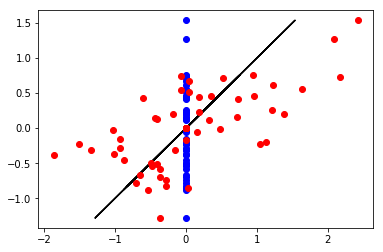

In [12]:
plt.plot(tst_forces[:, :], tst_forces[:, :], 'k-')
plt.plot(gp_2b_forces[:, :], tst_forces[:, :], 'bo')
plt.plot(gp_2b_forces[:, :] + gp_3b_forces[:, :], tst_forces[:, :], 'ro')

plt.show()

## Mapping

### 2-body

In [13]:
# ----------------------------------------
# Mapping
# ----------------------------------------

mapping_dists_2b = np.linspace(grid_start, r_cut, num_2b)
grid_2b = gp_2.build_grid(mapping_dists_2b, elementslist[0])


NameError: name 'gp_2' is not defined

In [ ]:
remap_2d_name = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}_num_{}.npy'.format(2, ntr, sigma_2b, r_cut, num_2b)
#np.save(directory / remap_2d_name, [elementslist, mapping_dists_2b, grid_2b._data[1]])

In [ ]:
plt.plot(mapping_dists_2b, -grid_2b(mapping_dists_2b, nu=0))
plt.plot(mapping_dists_2b, -grid_2b(mapping_dists_2b, nu=1))
plt.show()

### 3-body

In [14]:
# ----------------------------------------
# Mapping 3b
# ----------------------------------------

mapping_dists_3b = np.linspace(grid_start, r_cut, num_3b)
grid_3b = gp_3.build_grid(mapping_dists_3b, elementslist[0])


In [15]:
remap_3d_name = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}_num_{}.npy'.format(3, ntr, sigma_3b, r_cut, num_3b)
#np.save(directory / remap_3d_name, [elementslist, mapping_dists_3b, grid_3b.data])

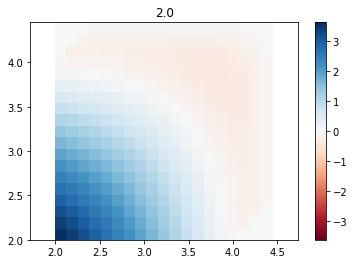

In [16]:
data = grid_3b.data
z_min, z_max = -np.max(np.abs(data)), np.max(np.abs(data))

for i in np.arange(0, len(mapping_dists_3b), 20):
    plt.title(mapping_dists_3b[i])
    dists_k = np.ones_like(mapping_dists_3b) * mapping_dists_3b[i]
    plt.pcolor(mapping_dists_3b, mapping_dists_3b, -data[:,:,i], cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')
    plt.show()

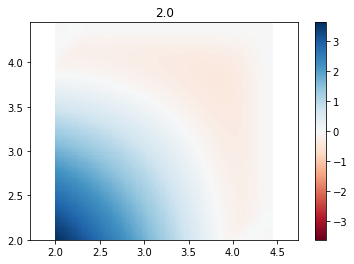

In [17]:
dist_range = mapping_dists_3b
dist_range = np.linspace(grid_start, r_cut, 100)

num = len(dist_range)

for i in range(0, len(mapping_dists_3b), 20):
    plt.title(dist_range[i])
    X, Y = np.meshgrid(dist_range, dist_range)
    g_data = grid_3b(X.flatten(), Y.flatten(), np.ones_like(X.flatten()) * mapping_dists_3b[i]).reshape(num, num)
    plt.pcolor(dist_range, dist_range, -g_data, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

## ASE Calculator

In [18]:

def rmse(x1, x2):
    rms = np.sqrt(np.sum(np.square(x1 - x2), axis=1))
    return np.mean(rms), np.std(rms)
    

In [ ]:
# grid_2b = TwoBodySingleSpeciesGrid.from_file(str(directory / 'MFF_2b_ntr_20_sig_0.30_cut_4.45.npy'))
# grid_3b = ThreeBodySingleSpeciesGrid.from_file(str(directory / 'MFF_3b_ntr_20_sig_0.60_cut_4.45.npy'))

# calc = ThreeBodySingleSpecies(r_cut=4.45, grid_2b=grid_2b, grid_3b=grid_3b)


# filename = directory / 'movie.xyz'
# traj = read(str(filename), index=slice(0,5))
# for atoms in traj[0:5]:

#     atoms.set_calculator(calc)

#     rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
#     print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))



In [ ]:
calc = TwoBodySingleSpecies(r_cut, grid_2b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj:

    atoms.set_calculator(calc)

    rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))
    
f2 = atoms.get_forces()

In [23]:
calc = ThreeBodySingleSpecies(r_cut, grid_3b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj:

    atoms.set_calculator(calc)
    rms_mean, rms_std = rmse(atoms.arrays['force'],  atoms.get_forces()/2.)
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))

f3 = atoms.get_forces()

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


MAEF on forces: 0.5480 +- 0.2582
MAEF on forces: 0.8749 +- 0.4240
MAEF on forces: 0.8495 +- 0.4078
MAEF on forces: 0.7100 +- 0.3273
MAEF on forces: 0.5702 +- 0.2616


In [ ]:
calc = CombinedSingleSpecies(r_cut, grid_2b, grid_3b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj:

    atoms.set_calculator(calc)

    rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))

f23 = atoms.get_forces()

In [ ]:
np.allclose(f2 + f3, f23)

## Manual tests

In [19]:

from asap3 import FullNeighborList

calc = ThreeBodySingleSpecies(r_cut, grid_3b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj[0:1]:
    force = atoms.arrays['force']
    
    atoms.set_calculator(calc)

    nl = FullNeighborList(r_cut, atoms=atoms, driftfactor=0.)
    
    gp_force = np.zeros((len(atoms),3))
    
    for i in range(len(atoms)):
        if i%10 == 0: print(i)
        conf = nl.get_neighbors(i)[1]
        elements = np.ones((conf.shape[0], 2))*elementslist[0]
        conf = np.hstack((conf, elements))
        gp_force[i,:] = gp_3.predict(np.array([conf])).flatten()
        
    rms_mean, rms_std = rmse(force,  atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))


0
10
20
30
40
50
60
70
80


INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


90
MAEF on forces: 0.8555 +- 0.5093


In [20]:
gp_force[0]

array([0.16679079, 0.88558956, 0.        ])

In [21]:
atoms.arrays['force'][0]

array([0.10471069, 0.89021256, 0.        ])

In [22]:
atoms.get_forces()[0]

array([0.17538345, 0.90302246, 0.        ])

In [ ]:
traj[0].calc.results['forces'][0]

In [ ]:

forces = np.zeros((len(atoms), 3))
potential_energies = np.zeros((len(atoms), 1))

indices, distances, positions = calc.find_triplets()

d_ij, d_jk, d_ki = np.hsplit(distances, 3)
mapped = calc.grid_3b.ev_all(d_ij, d_jk, d_ki)

for (i, j, k), energy, dE_ij, dE_jk, dE_ki in zip(indices, mapped[0], mapped[1], mapped[2], mapped[3]):
    forces[i] += (- positions[(i, j)] * dE_ij - positions[(i, k)] * dE_ki)/2.
    forces[j] += (- positions[(j, k)] * dE_jk - positions[(j, i)] * dE_ij)/2.
    forces[k] += (- positions[(k, i)] * dE_ki - positions[(k, j)] * dE_jk)/2.
    
    potential_energies[[i, j, k]] += energy

#print(forces)   

if 'energy' in calc.results:
    calc.results['energy'] += np.sum(potential_energies)
else:
    self.results['energy'] = np.sum(potential_energies)

if 'forces' in calc.results:
    calc.results['forces'] += forces
else:
    self.results['forces'] = forces
    
    

In [ ]:
c = tst_confs[np.random.randint(25)]

In [ ]:
global_gp_force = np.zeros(3)
global_m_force = np.zeros(3)
global_gp_force2 = gp_3.predict(np.array([c]))

for i in np.arange(c.shape[0]):
    for j in np.arange(i):
        r1, r2 = c[i, 0:3], c[j,0:3]
        r3 = r2-r1
        d1, d2, d3 = np.linalg.norm(r1) , np.linalg.norm(r2) , np.linalg.norm(r3)          
        n1, n2, n3 = r1/d1, r2/d2, r3/d3
        
        local_conf = np.array([[c[i],c[j]]])
        
        gp_e = gp_3.predict_energy(local_conf)
        gp_f = gp_3.predict(local_conf)
        
        if d1<= r_cut and d2 <= r_cut and d3 <= r_cut:
            e, de1, de2, de3 = calc.grid_3b.ev_all(d1, d2, d3)
        
            f = (- de1 * r1 - de2 * r2)/1.
            global_m_force += f.flatten()
        else:
            assert((gp_f == np.zeros(3)).all())
        
        global_gp_force += gp_f.flatten()
        


In [ ]:
#global_gp_force - global_m_force

In [ ]:
global_m_force

In [ ]:
global_gp_force

In [ ]:
global_gp_force2

In [ ]:
np.nanmean(global_m_force/global_gp_force)

In [ ]:
calc.grid_3b.ev_all(3, 3, 3)

In [ ]:
xgrid = np.linspace(2., 4.45, 100)
profile = np.zeros(xgrid.shape[0])
grad = np.zeros(xgrid.shape[0])
for i in np.arange(xgrid.shape[0]):
    profile[i] = calc.grid_3b.ev_all(xgrid[i], 2.3, 3)[0] 
    grad[i] = calc.grid_3b.ev_all(xgrid[i], 2.3, 3)[1]

npgrad = np.gradient(profile, xgrid )

In [ ]:
#plt.plot(xgrid, profile)
plt.plot(xgrid, grad)
plt.plot(xgrid, npgrad)
